# NYPD Allegations
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the outcome of an allegation (might need to feature engineer your output column).
    * Predict the complainant or officer ethnicity.
    * Predict the amount of time between the month received vs month closed (difference of the two columns).
    * Predict the rank of the officer.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
- I am going to predict the outcome of allegation based on other features/columns. In project3, when cleaning data and doing EDA, I have created a column result that categorizes the outcome of the allegation as "unsubstantiated", "substantiated", and "exonerated", so I didn't do additional feature engineering. This problem I am investigating is a classification problem, as we're trying to predict the categorical outcomes of the allegation. Given information about the case itself, police's info, and complainant's info, we'll be predicting the allegation result, and evaluating them using accuracy, the proportion of correct allegation prediction. 
- I provided some of the code from project3 about how I created additional columns during EDA and data cleaning, such as duration of case(duration), difference in age between officer and complainant(age_diff), and result of allegation(result)

### Baseline Model
The baseline model utilizes several quantitative features: duration, month_received, year_received, month_closed , year_closed, as well as categorical features processed with one_hot_encoding: mos_gender, mos_ethnicity , fado_type , rank_now. As we utilize accuracy(default scoring metric of randomForest classifier), this is a good metric because the proportion of correctly identified allegation results indicates a better, optimized model. The model is composed of original quantitative features and one-hot-encoded categorical features that I consider to be more useful, then every input is placed into a randomForestClassifier. After running this model, we get a training accuracy around 84% and a testing accuracy of 0.54. This baseline model does need more improvement.

### Final Model
- For the final model, I tried "binning" month_received and year_received, since the era of the occurrence of the case is also related to cultural background, which might sway the allegation result based on certain traits of the officer, granting them potential priveleges and abuse of power,possibly. Moreover, the month/seasons of the occurrence of the case might also influence the result of the allegation case. 
- Besides these, I also normalized variable duration, scaling it so a more optimized model can be acquired. For month closed and year closed, I leaved it at it is, because when testing on final model, it decreases the model's testing accuracy. Comparing to date of occurrence, the date of case being closed is less importance, since it doesn't really reflect the background of the complaint, and the date of case being closed might not be directly influenced by the result of the case itself, but other trivial reasons(such as delay of case due to exceeding number of cases). Yet, this is just an assumption, and. we aren't certain if this is the actual reason.
- I ended up choosing randomForestClassifier instead of DecisionTreeClassifier because randomForestClassifier yields a slightly higher accuracy. 
- In terms of parameters that I experimented for GridSearch, I tried variations on bin size for month_received and year_received, as well as parameters of RandomForestClassifier(max_depth). I wanted to try more parameters, but the time required is too long and excessive. 
- The results I acquire(accuracy as metric) was roughly 1% higher than the original model, suggesting that the tuning of parameters as well as binning month_received and year_received didn't help that much.Possible reasons included that the number of feature-engineered features aren't enough. Moreover, months_received doesn't influence allegation result. Year of the occurrence doesn't really sway the results either, possibly suggesting that the cultural background of the occurrence doesn't really affect the result of the case. If a better model is acquired, more sophisticated feature-engineered column is needed as well as in-depth EDA.

### Fairness Evaluation
- I am evaluating on the duration column. When drawing a histogram, there is a drop at the duration = 10 months. Therefore, I would like to investigate whether cases closed within 10 months are as "fair" as cases closed more than 10 months. 
- FP=we classify as substantiated but in reality it isn't
- FN=we classify as non-substantiated but in reality it is substantiated
- True positive: classify as substantiated and in reality it is substantiated
- Precision is utilized in this case, because false positive is more fatal, as we might be underrepresenting disadvantaged complainants, assuming they're actually substantiated while they aren't
- I binarize the allegation result into substantiated and non-substantiated(unsubstantiated or exonerated) as well as binarize duration(for testing purposes)
- Hypothesis
    - Null Hypothesis: my model is fair; the precision for my two subsets are roughly the same
    - Alternative Hypothesis: my model is unfair; the complaints for the longer-duration subset less fair than the short-duration subset
- Difference in precision was taken as the statistics of permutation testing
- Result: The p value gotten is 0.04. On a signficance level of 0.05, the null hypothesis rejected. In other words, the complaints for the longer-duration complaints less fair than the short-duration complaints. This might be true because longer duration cases makes judges out of patience, more emotional and inclined to amke it unsubstantiated.



# Code

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import calendar
import seaborn as sns

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,Binarizer,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,learning_curve, cross_val_score
from sklearn.feature_selection import SelectKBest,f_classif, f_regression,chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier



import warnings
warnings.filterwarnings("ignore")



%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [9]:
allegations=pd.read_csv("cleaned_allegations.csv")
#This is some of the code I did for project3,related to adding features
#created age_diff that gets the difference in age between police officer and complainant
#created duration that gets the total months lasted between cased opened and case closed
'''
#Create column duration(in months) that calculates the amount of time it takes to resolve a case
allegations["duration"]=12*(allegations["year_closed"]-allegations["year_received"])+(allegations["month_closed"]-allegations["month_received"])
#Create column age_diff that calculates difference between officer age and complainant age
allegations["age_diff"]=allegations["mos_age_incident"]-allegations["complainant_age_incident"]
#Create column result that categorizes the board disposition as either unsubstantiated, exonerated, or substantiated
allegations["result"]=allegations["board_disposition"].copy()
allegations["result"]=allegations["result"].apply(lambda x: "Substantiated" if x.split(" ")[0]=="Substantiated" else x)
'''
allegations.columns
#allegations.isnull().sum()
(allegations["year_received"]<2014).mean()
allegations["complainant_ethnicity"]=allegations["complainant_ethnicity"].fillna("None")
allegations["bin_result"]=allegations["result"].apply(binarize_result)
#allegations=fill_null_values(allegations,"complainant_gender")

allegations["complainant_gender"]=allegations["complainant_gender"].apply(convert_gender)
allegations["special_gender"]=allegations["complainant_gender"].apply(lambda x: x=="O")
allegations["same_gender"]=(allegations["complainant_gender"]==allegations["mos_gender"])

allegations["Unnamed: 0"]=allegations["Unnamed: 0"].astype(str)
allegations["unique_mos_id"]=allegations["unique_mos_id"].astype(str)
allegations["shield_no"]=allegations["shield_no"].astype(str)
allegations["complaint_id"]=allegations["complaint_id"].astype(str)
allegations["precinct"]=allegations["precinct"].astype(str)

allegations["mos_same_rank"]=(allegations["rank_abbrev_incident"]==allegations["rank_abbrev_now"])
allegations["mos_same_command"]=(allegations["command_at_incident"]==allegations["command_now"])
allegations["contact_type"]=allegations["contact_reason"].str.replace("-", " ").str.split(' ').str[0]
allegations["contact_type"]=allegations["contact_type"].fillna("NAN")

#allegations["complainant_ethnicity"]=allegations["complainant_ethnicity"].str.replace("None", "Refused")
allegations.loc[allegations["complainant_ethnicity"]=="None","complainant_ethnicity"]=np.NaN
allegations=fill_null_values(allegations,"complainant_ethnicity")
allegations["same_ethnicity"]=(allegations["mos_ethnicity"]==allegations["complainant_ethnicity"])
allegations["rank_abbrev_incident"]=allegations["rank_abbrev_incident"].apply(map_rank_order)
allegations["rank_incident"]=allegations["rank_incident"].map(map_cat_rank)
allegations["rank_now"]=allegations["rank_now"].map(map_cat_rank)
allegations["rank_diff"]=allegations["rank_now"]-allegations["rank_incident"]
allegations["is_danger"]=get_danger_allegation(allegations["allegation"].str.lower())
allegations["is_sexual"]=all_contains_sex(allegations["allegation"].str.lower())




ohe=OneHotEncoder(handle_unknown="ignore")
top_features=['PD', 'Other', 'Report', 'Moving', 'Execution', 'C/V', 'Parking','Traffic', 'Patrol', 'EDP']
ohe.fit(pd.DataFrame(top_features))
features = pd.DataFrame(ohe.transform(allegations[["contact_type"]]).toarray())
allegations=allegations.join(features)

allegations=fill_null_values(allegations,"allegation")
ohe=OneHotEncoder(handle_unknown="ignore")
top_features=['Physical force', 'Word', 'Stop', 'Search (of person)', 'Frisk']
ohe.fit(pd.DataFrame(top_features))
features = pd.DataFrame(ohe.transform(allegations[["allegation"]]).toarray())
features.columns=["all_"+str(col) for col in features.columns]
allegations=allegations.join(features)
allegations=allegations.rename(columns={0:"all_0",1:"all_1",2:"all_2",3:"all_3",4:"all_4"})

#alleations["fado_police"]
print(len(allegations.columns))
allegations.columns=np.concatenate((allegations.columns[:46].to_numpy(), np.array(["ctype_"+str(i) for i in range(10)])))
allegations.columns
allegations["is_danger"].value_counts()
#.value_counts().sort_index()

56


False    32456
True       902
Name: is_danger, dtype: int64

In [10]:
def fill_null_values(df, col_name):
    num_null = df[col_name].isnull().sum() # number of nulls
    fill_values = df[col_name].dropna().sample(num_null, replace=True)  # draw fill vals from distribution
    fill_values.index = df.loc[df[col_name].isnull()].index  # align the index
    df = df.fillna({col_name: fill_values.to_dict()}) 
    return df
#allegations["duration"].hist()
pt = PowerTransformer()

temp = pd.DataFrame(
    pt.fit_transform(allegations[["mos_age_incident", "complainant_age_incident"]]), columns=["mos_age_incident", "complainant_age_incident"]
)


#allegations[["rank_incident"]].hist(figsize=(12, 4));
#allegations["allegation"].value_counts(normalize=True)[:10]
allegations["complainant_gender"].value_counts()
#allegations.groupby("is_sexual")["bin_result"].mean()
allegations['allegation'].value_counts()

Physical force                             4849
Word                                       3942
Stop                                       2300
Search (of person)                         2047
Frisk                                      1926
                                           ... 
Sex Miscon (Sexual Harassment, Gesture)       2
Sexist Remark                                 1
Questioned immigration status                 1
Oriental                                      1
Other Asian                                   1
Name: allegation, Length: 115, dtype: int64

In [11]:
'''sub_df=allegations[allegations["bin_result"]==0]
drop_cols=["Unnamed: 0", "unique_mos_id","first_name","last_name","shield_no","complaint_id"]
num_df=sub_df.select_dtypes(include='object').drop(columns=drop_cols)
#black as complainant ethnicity affects substantiated ratio
num_df["complainant_ethnicity"].value_counts(normalize=True)
#officer with substantiated cases are less likely to be promoted
(num_df["rank_abbrev_incident"]==num_df["rank_abbrev_now"]).mean()
(num_df["allegation"].value_counts(normalize=True))[:5]'''
counts=allegations.groupby(["allegation"])["bin_result"].mean().sort_values()
counts
#num_df

allegation
Other Asian                                 0.000000
Failed to Obtain Language Interpretation    0.000000
Sexual Misconduct (Sexual Humiliation)      0.230769
Retaliatory summons                         0.257732
Retaliatory arrest                          0.292517
                                              ...   
Gun pointed/gun drawn                       1.000000
Sex Miscon (Sexual Harassment, Gesture)     1.000000
Sexist Remark                               1.000000
Refusal to show arrest warrant              1.000000
Gun pointed                                 1.000000
Name: bin_result, Length: 115, dtype: float64

In [12]:
unsub_df=allegations[allegations["bin_result"]==1]
drop_cols=["Unnamed: 0", "unique_mos_id","first_name","last_name","shield_no","complaint_id"]
num_df=unsub_df.select_dtypes(include='object').drop(columns=drop_cols)

num_df["complainant_ethnicity"].value_counts(normalize=True)
(num_df["rank_abbrev_incident"]==num_df["rank_abbrev_now"]).mean()
(num_df["allegation"].value_counts(normalize=True))[:5]

#allegations.groupby("allegation")["bin_result"].mean()
allegations.pivot_table(index="bin_result", columns="allegation",aggfunc="count")
allegations.groupby(["contact_reason"])["bin_result"].mean().sort_index()

KeyError: 'rank_abbrev_incident'

In [13]:
temp=allegations.groupby(["allegation"])["bin_result"].mean().sort_values()[-20:]
#plt.scatter(temp.index, temp.values)
#plt.show()
#temp.hist()
allegations["complainant_gender"].value_counts()
#allegations["rank_incident"].value_counts()

M    24058
F     5021
O     4279
Name: complainant_gender, dtype: int64

In [6]:
def convert_gender(x):
    if(x=="Male" or x=="Female"):
        return x[0]
    return "O"
def map_rank_order(x):
    order=np.array(["POM","POF", "PO","SGT","SSA","SDS","DT3","DET","DT2","DT1","DTS","LT","LSA", "LCD", "CPT","DI","INS","DC"])
    return np.where(order==x)[0][0]+1
def map_cat_rank(x):
    order=np.array(["Police Officer", "Detective","Sergeant", "Lieutenant", "Captain", "Deputy Inspector", "Inspector","Chiefs and other ranks"])
    return np.where(order==x)[0][0]+1
def get_danger_allegation(s):
    return s.str.contains("gun",na=False)
def all_contains_sex(s):
    return s.str.contains("sex",na=False)


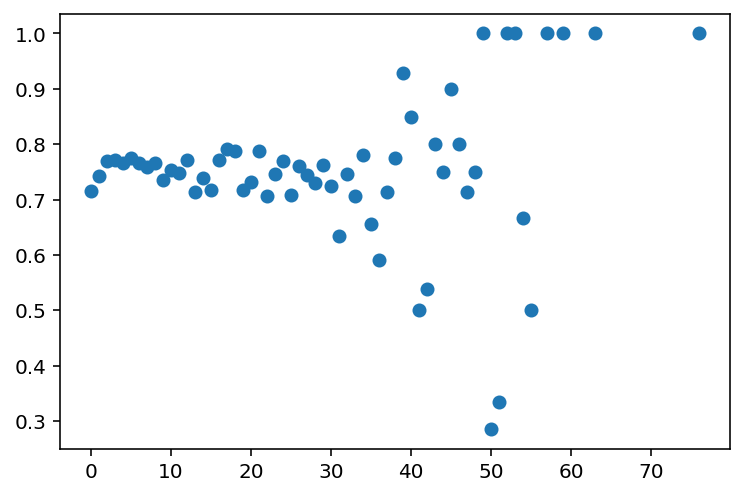

In [14]:
temp_df=allegations.copy()
temp_df["age_diff"]=temp_df["age_diff"].apply(np.abs)
temp=temp_df.groupby("age_diff")["bin_result"].mean()
plt.scatter(temp.index, temp.values)
plt.show()



In [15]:
allegations["rank_now"].value_counts()

1    10298
2     9917
3     7751
4     3696
5      735
6      435
8      312
7      214
Name: rank_now, dtype: int64

### Baseline Model

In [16]:
# Predict the result of the cases(variable result is constructed in project3 when cleaning data, so I didn't do feature engineering)
cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
cat_cols=["mos_gender", "mos_ethnicity","fado_type","complainant_ethnicity", "month_received","month_closed"]


preproc = ColumnTransformer(
    transformers=[
        ('regular', FunctionTransformer(lambda x: x), ["duration","month_received", "year_received","month_closed","year_closed","rank_now","rank_incident"]),
        #('log_c2', FunctionTransformer(lambda x: np.log(x)), ["c2"]),
        #('year_binarizer', )
        ('cat', cat_transformer, cat_cols)
    ])
pl = Pipeline(steps=[('preprocessor', preproc),('classify', RandomForestClassifier())])

X_tr, X_ts, y_tr, y_ts = train_test_split(allegations.drop(columns=["result","bin_result"]), allegations.bin_result, test_size=0.25)



pl.fit(X_tr, y_tr)
pl.score(X_ts, y_ts)

0.770863309352518

## Final Model
### Predict if the case is substantiated based on given info(suppose time of prediction is today)

In [17]:
# Predict the result of the cases(variable result is constructed in project3 when cleaning data, so I didn't do feature engineering)

#fado type, rank_now, rank_incident, mos_ethnicity, mos_gender, complainant ethnicity
cat_cols=["mos_gender", "mos_ethnicity","fado_type","complainant_ethnicity", "month_received","month_closed"]

'''preproc = ColumnTransformer(
    transformers=[
        #('imp_ohe', cat_imp_transformer, ["complainant_gender"]),
        ('imp_scale', impute_scale_transformer, ["mos_age_incident","complainant_age_incident"]),
        ('regular', FunctionTransformer(lambda x: x), ["rank_diff", "same_gender", "rank_abbrev_incident","rank_incident", "rank_now"]+["ctype_"+str(i) for i in range(10)]),
        ('normalize', StandardScaler(), ["duration"]),
        ('ohe_contact', FunctionTransformer(lambda x: x=="PD suspected C/V of violation/crime - street"), ["contact_reason"]),
        ('ctype_convert', FunctionTransformer(lambda x: x=="PD"), ["contact_type"]),
        
        #('year_bin_ss', StandardScaler(), ["year_received", "year_closed"]),
        #('year_bin', KBinsDiscretizer(), ["year_received", "year_closed"]),
        
        #('monthR_bin', KBinsDiscretizer(n_bins=3), ["month_received"]),
        #('monthC_bin', KBinsDiscretizer(n_bins=5), ["month_closed"]),
        ('scale_month', StandardScaler(), ["month_received", "month_closed"]),
        
        ('duration_bin', KBinsDiscretizer(encode='ordinal'), ["duration"]),
        ('binarize_duration', Binarizer(threshold=24), ["duration"]),
        ('age_bin', impute_bin_transformer, ["age_diff"]),

        #('cat_allegation', impute_allegation_transform, ["allegation"]),
        ('cat', cat_transformer, cat_cols)
    ])'''
#Change normalize standScaler to PowerTransformer

preproc = ColumnTransformer(
    transformers=[
        #('imp_ohe', cat_imp_transformer, ["complainant_gender"]),
        ('imp_scale', impute_scale_transformer, ["mos_age_incident","complainant_age_incident"]),
        ('regular', FunctionTransformer(lambda x: x), ["special_gender", "is_danger","is_sexual"]+["all_"+str(i) for i in range(5)]+["ctype_"+str(i) for i in range(10)]),
        ('normalize', StandardScaler(), ["duration","year_received", "year_closed","rank_diff", "rank_abbrev_incident","rank_incident", "rank_now"]),
        ('ohe_contact', FunctionTransformer(lambda x: x=="PD suspected C/V of violation/crime - street"), ["contact_reason"]),
        
        #('year_bin', KBinsDiscretizer(), ["year_received", "year_closed"]),
        
        #('monthR_bin', KBinsDiscretizer(n_bins=3), ["month_received"]),
        #('monthC_bin', KBinsDiscretizer(n_bins=5), ["month_closed"]),
        ('scale_month', StandardScaler(), ["month_received", "month_closed"]),
        
        #TBA('duration_bin', KBinsDiscretizer(encode='ordinal'), ["duration"]),
        
        #TBA('binarize_duration', Binarizer(threshold=24), ["duration"]),
        ('age_bin', impute_bin_transformer, ["age_diff"]),

        #('cat_allegation', impute_allegation_transform, ["allegation"]),
        ('cat', cat_transformer, cat_cols+["complainant_gender"])
    ])

pl = Pipeline(steps=[('preprocessor', preproc), ('classify', RandomForestClassifier())])
#pl = Pipeline(steps=[('preprocessor', preproc), ('classify', LinearSVC())])
#pl = Pipeline(steps=[('preprocessor', preproc), ('classify', LogisticRegression())])
#pl = Pipeline(steps=[('preprocessor', preproc), ('classify', SGDClassifier())])

#pl=Pipeline(steps=[('preprocessor', preproc), ('classify', SelectKBest(score_func=f_classif, k=10))])

test_scores=[]
train_scores=[]
features=[]
for i in range(20):
    #min_samples_split=2, random_state=4,
    X_tr, X_ts, y_tr, y_ts = train_test_split(allegations.drop(columns=["result","bin_result"]), allegations.bin_result, test_size=0.15)
    #pl_select[1].k=i
    pl.fit(X_tr, y_tr)
    
    test_scores.append(pl.score(X_ts, y_ts))
    train_scores.append(pl.score(X_tr, y_tr))
    #features.append(pl[1].get_support())
test_scores=np.array(test_scores)
train_scores=np.array(train_scores)
print(test_scores)
print(train_scores)
#print(features[0])
#print(allegations.columns[features])

[0.78597122 0.78017586 0.78417266 0.78597122 0.78936851 0.77877698
 0.79136691 0.77358114 0.78976819 0.78577138 0.79796163 0.79276579
 0.80035971 0.78617106 0.77338129 0.78517186 0.78177458 0.7813749
 0.78257394 0.78257394]
[0.97428934 0.97506525 0.97368978 0.97316075 0.97453622 0.97460676
 0.97309022 0.97425407 0.97361924 0.97421881 0.97435988 0.97337236
 0.97326656 0.97365451 0.97443042 0.97393666 0.97390139 0.97453622
 0.97379558 0.97414827]


In [18]:
(test_scores.mean(), train_scores.mean())
temp.columns


AttributeError: 'Series' object has no attribute 'columns'

In [1]:
#plt.scatter(X_tr["year_received"], y_tr)
#plt.scatter(X_tr["year_received"], pl[1].predict(X_tr))
for col_name in allegations.columns:
    allegations=fill_null_values(allegations, col_name)


features=[]
all_scores=[]
all_cv_scores=[]
temp=allegations.select_dtypes(include=["int64","float64","bool"]).join(pd.get_dummies(allegations[cat_cols+["complainant_gender"]]))
for i in range(5, 6):
    selectkbest = SelectKBest(f_classif, k=i)
    X_new = selectkbest.fit_transform(temp, allegations.bin_result)
    features.append(selectkbest.get_support())

    X_tr, X_ts, y_tr, y_ts = train_test_split(X_new, allegations["bin_result"] , test_size=0.2)
    rc=RandomForestClassifier(criterion='entropy', )
    rc.fit(X_tr, y_tr)
    #rc=LinearSVC()
    all_scores.append(rc.score(X_ts, y_ts))
    all_cv_scores.append(np.mean(cross_val_score(rc, temp, allegations["bin_result"], cv=5)))
maxscore = np.argmax(all_scores)
print(maxscore)
print(all_scores[maxscore])
print(all_cv_scores[maxscore])
print(temp.columns[features[maxscore]])
#allegations.dtypes
#temp.columns[features[0]]


NameError: name 'allegations' is not defined

In [146]:
'''maxscore = np.argmax(all_scores)
print(maxscore)
print(all_scores[maxscore])
print(all_cv_scores[maxscore])
print(temp.columns[features[maxscore]])
temp.info()'''

temp=allegations.select_dtypes(include=["int64","float64","bool"]).join(pd.get_dummies(allegations[cat_cols+["complainant_gender"]]))

X_tr, X_ts, y_tr, y_ts = train_test_split(temp, allegations["bin_result"] , test_size=0.2)
#rc=RandomForestClassifier(criterion='entropy')
#rc=LinearSVC()
#rc=LogisticRegression()


rc.fit(X_tr, y_tr)
print(rc.score(X_tr, y_tr))
rc.score(X_ts, y_ts)
#allegations.bin_result.shape

0.9759799145619426


0.7621402877697842

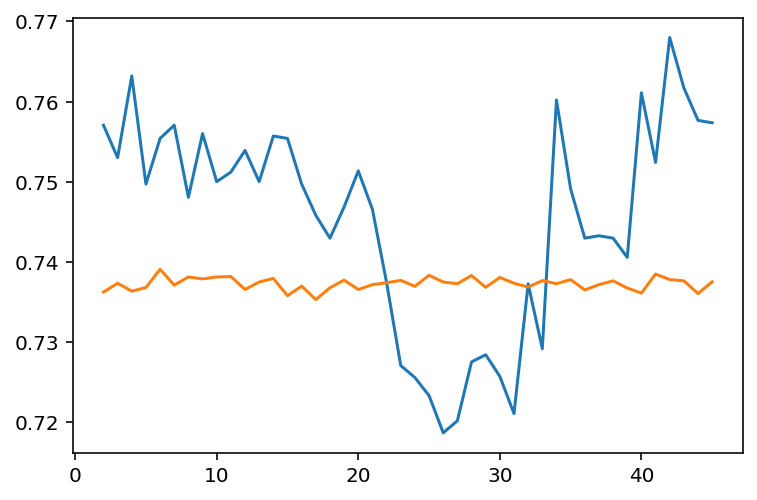

In [159]:
u=allegations.select_dtypes(include=["int64","float64","bool"]).join(pd.get_dummies(allegations[cat_cols]))

allegations.loc[allegations["is_danger"].isnull(),"allegation"]
#plt.plot(list(zip(np.arange(2, len(temp.columns)-1),all_scores)))
plt.plot(np.arange(2, len(temp.columns)), all_scores)
plt.plot(np.arange(2, len(temp.columns)), all_cv_scores)


In [7]:
#Helper Transformers/Pipelines

def convert_month(x):
    out=pd.DataFrame([str(calendar.month_name[month]) for month in x.values.T[0]], index=np.arange(len(x)), columns=["month_received"])
    return out

cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False)),
        #('pca', PCA(svd_solver='auto'))
    ])
cat_imp_transformer=Pipeline(steps=[
        ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])

impute_scale_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scale', StandardScaler())
])

impute_bin_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('bin', KBinsDiscretizer(n_bins=3))
    
])


In [198]:
#GridSearchCV
parameters = {
    #'preprocessor__age_bin__bin__n_bins':np.arange(2,6,1),
    #"preprocessor__binarize_duration__threshold":np.arange(20,31,1),
    #'preprocessor__age_bin__binarize__threshold':np.arange(30,51,4),
    #'preprocessor__monthC_bin__n_bins':np.arange(2,13,1),
    #"classify__max_depth": [None,2,3,4,5,7,10,13,15], 
    "classify__random_state":[None,3,5,10],
    "classify__min_samples_split":[None,2,5,10],
    'classify__n_estimators': [300, 500, 800, 1000],
    #'classify__criterion': ['gini', 'entropy'],
}
'''classify__max_depth': [None,2,3,4,5,7,10,13,15], 
'classify__min_samples_split':[None,2,3,5,7,10,15],
'classify__min_samples_leaf':[None,2,3,5,7,10,15,20]'''
clf=GridSearchCV(pl, parameters, cv = 2)
clf.fit(X_tr, y_tr)
clf.best_estimator_.score(X_ts, y_ts)


0.7909172661870504

In [199]:
#Optimized model: min_sample_leaf=2, max_depth & min_samples_split=None
clf.best_estimator_[1]
#clf.best_estimator_.score(X_tr, y_tr)

#clf.best_estimator_.score(X_tr, y_tr)
#KBinsDiscretizer?

RandomForestClassifier(n_estimators=1000, random_state=10)

### Predict the officer ethnicity.

In [193]:
#EDA
#allegations.groupby("rank_now").count()
#.hist()

,Unnamed: 0,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,...,ctype_0,ctype_1,ctype_2,ctype_3,ctype_4,ctype_5,ctype_6,ctype_7,ctype_8,ctype_9
rank_now,,,,,,,,,,,,,,,,,,,,,
1,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,...,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298
2,9917,9917,9917,9917,9917,9917,9917,9917,9917,9917,...,9917,9917,9917,9917,9917,9917,9917,9917,9917,9917
3,7751,7751,7751,7751,7751,7751,7751,7751,7751,7751,...,7751,7751,7751,7751,7751,7751,7751,7751,7751,7751
4,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,...,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696
5,735,735,735,735,735,735,735,735,735,735,...,735,735,735,735,735,735,735,735,735,735
6,435,435,435,435,435,435,435,435,435,435,...,435,435,435,435,435,435,435,435,435,435
7,214,214,214,214,214,214,214,214,214,214,...,214,214,214,214,214,214,214,214,214,214
8,312,312,312,312,312,312,312,312,312,312,...,312,312,312,312,312,312,312,312,312,312


In [182]:
cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
cat_cols=["mos_gender","fado_type","complainant_ethnicity", "month_received","month_closed"]


preproc = ColumnTransformer(
    transformers=[
        ('regular', FunctionTransformer(lambda x: x), ["duration","month_received", "year_received","month_closed","year_closed","rank_now","rank_incident", "bin_result"]),
        #('log_c2', FunctionTransformer(lambda x: np.log(x)), ["c2"]),
        #('year_binarizer', )
        #
        ('cat', cat_transformer, cat_cols)
    ])
pl = Pipeline(steps=[('preprocessor', preproc),('classify', RandomForestClassifier())])

X_tr, X_ts, y_tr, y_ts = train_test_split(allegations.drop(columns=["mos_ethnicity","same_ethnicity"]), allegations.mos_ethnicity, test_size=0.25)



pl.fit(X_tr, y_tr)
print(pl.score(X_tr, y_tr))
pl.score(X_ts, y_ts)

0.7106714628297363

In [175]:
cat_cols=["mos_gender","fado_type","complainant_ethnicity", "month_received","month_closed"]



temp=allegations.select_dtypes(include=["int64","float64","bool"]).join(pd.get_dummies(allegations[cat_cols+["complainant_gender"]]))
temp=temp.drop(columns=["same_ethnicity"])


features=[]
all_scores=[]
all_cv_scores=[]
for i in range(5, 15):
    selectkbest = SelectKBest(f_classif, k=i)
    X_new = selectkbest.fit_transform(temp, allegations.mos_ethnicity)
    features.append(selectkbest.get_support())
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_new, allegations["mos_ethnicity"] , test_size=0.2)
    rc=RandomForestClassifier(criterion='entropy', )
    rc.fit(X_tr, y_tr)
    #rc=LinearSVC()
    all_scores.append(rc.score(X_ts, y_ts))
    all_cv_scores.append(np.mean(cross_val_score(rc, temp, allegations["mos_ethnicity"], cv=5)))
maxscore = np.argmax(all_scores)
print(maxscore)
print(all_scores[maxscore])
print(all_cv_scores[maxscore])
print(temp.columns[features[maxscore]])

'''
X_tr, X_ts, y_tr, y_ts = train_test_split(temp, allegations["mos_ethnicity"] , test_size=0.2)
rc=RandomForestClassifier()
rc.fit(X_tr, y_tr)
print(rc.score(X_tr, y_tr))
rc.score(X_ts, y_ts)'''
#allegations.info()


5
0.5614508393285371
0.494573711440082
Index(['special_gender', 'mos_same_rank', 'mos_same_command', 'ctype_0',
       'mos_gender_F', 'mos_gender_M', 'complainant_ethnicity_Asian',
       'complainant_ethnicity_Black', 'complainant_ethnicity_Hispanic',
       'complainant_gender_O'],
      dtype='object')


'\nX_tr, X_ts, y_tr, y_ts = train_test_split(temp, allegations["mos_ethnicity"] , test_size=0.2)\nrc=RandomForestClassifier()\nrc.fit(X_tr, y_tr)\nprint(rc.score(X_tr, y_tr))\nrc.score(X_ts, y_ts)'

0.9400831401390999


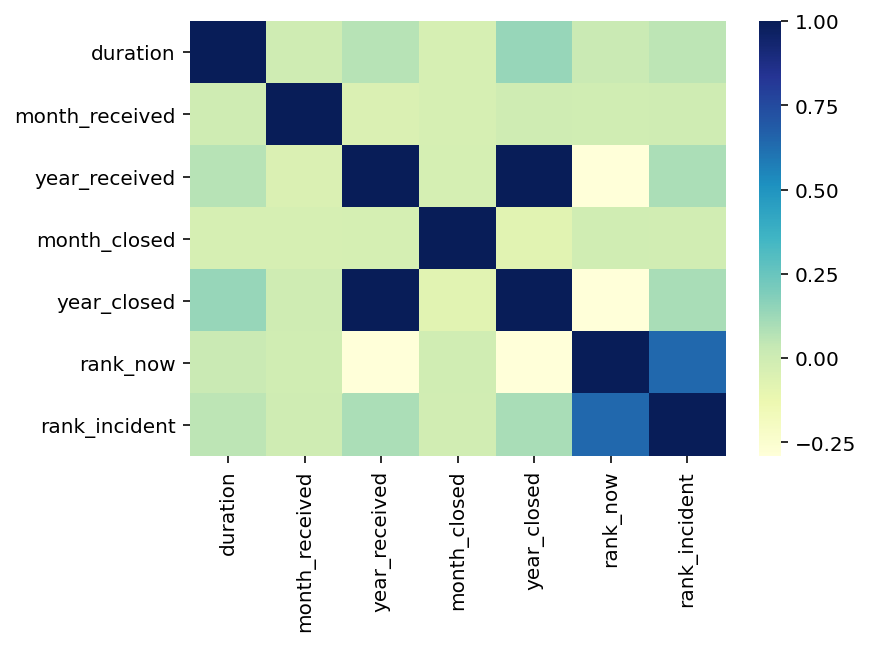

In [183]:
#plt.plot(np.arange(5, 15), all_scores)
#plt.plot(np.arange(5, 15), all_cv_scores)
sns.heatmap(allegations[["duration","month_received", "year_received","month_closed","year_closed","rank_now","rank_incident"]].corr(), cmap="YlGnBu")
#temp.columns


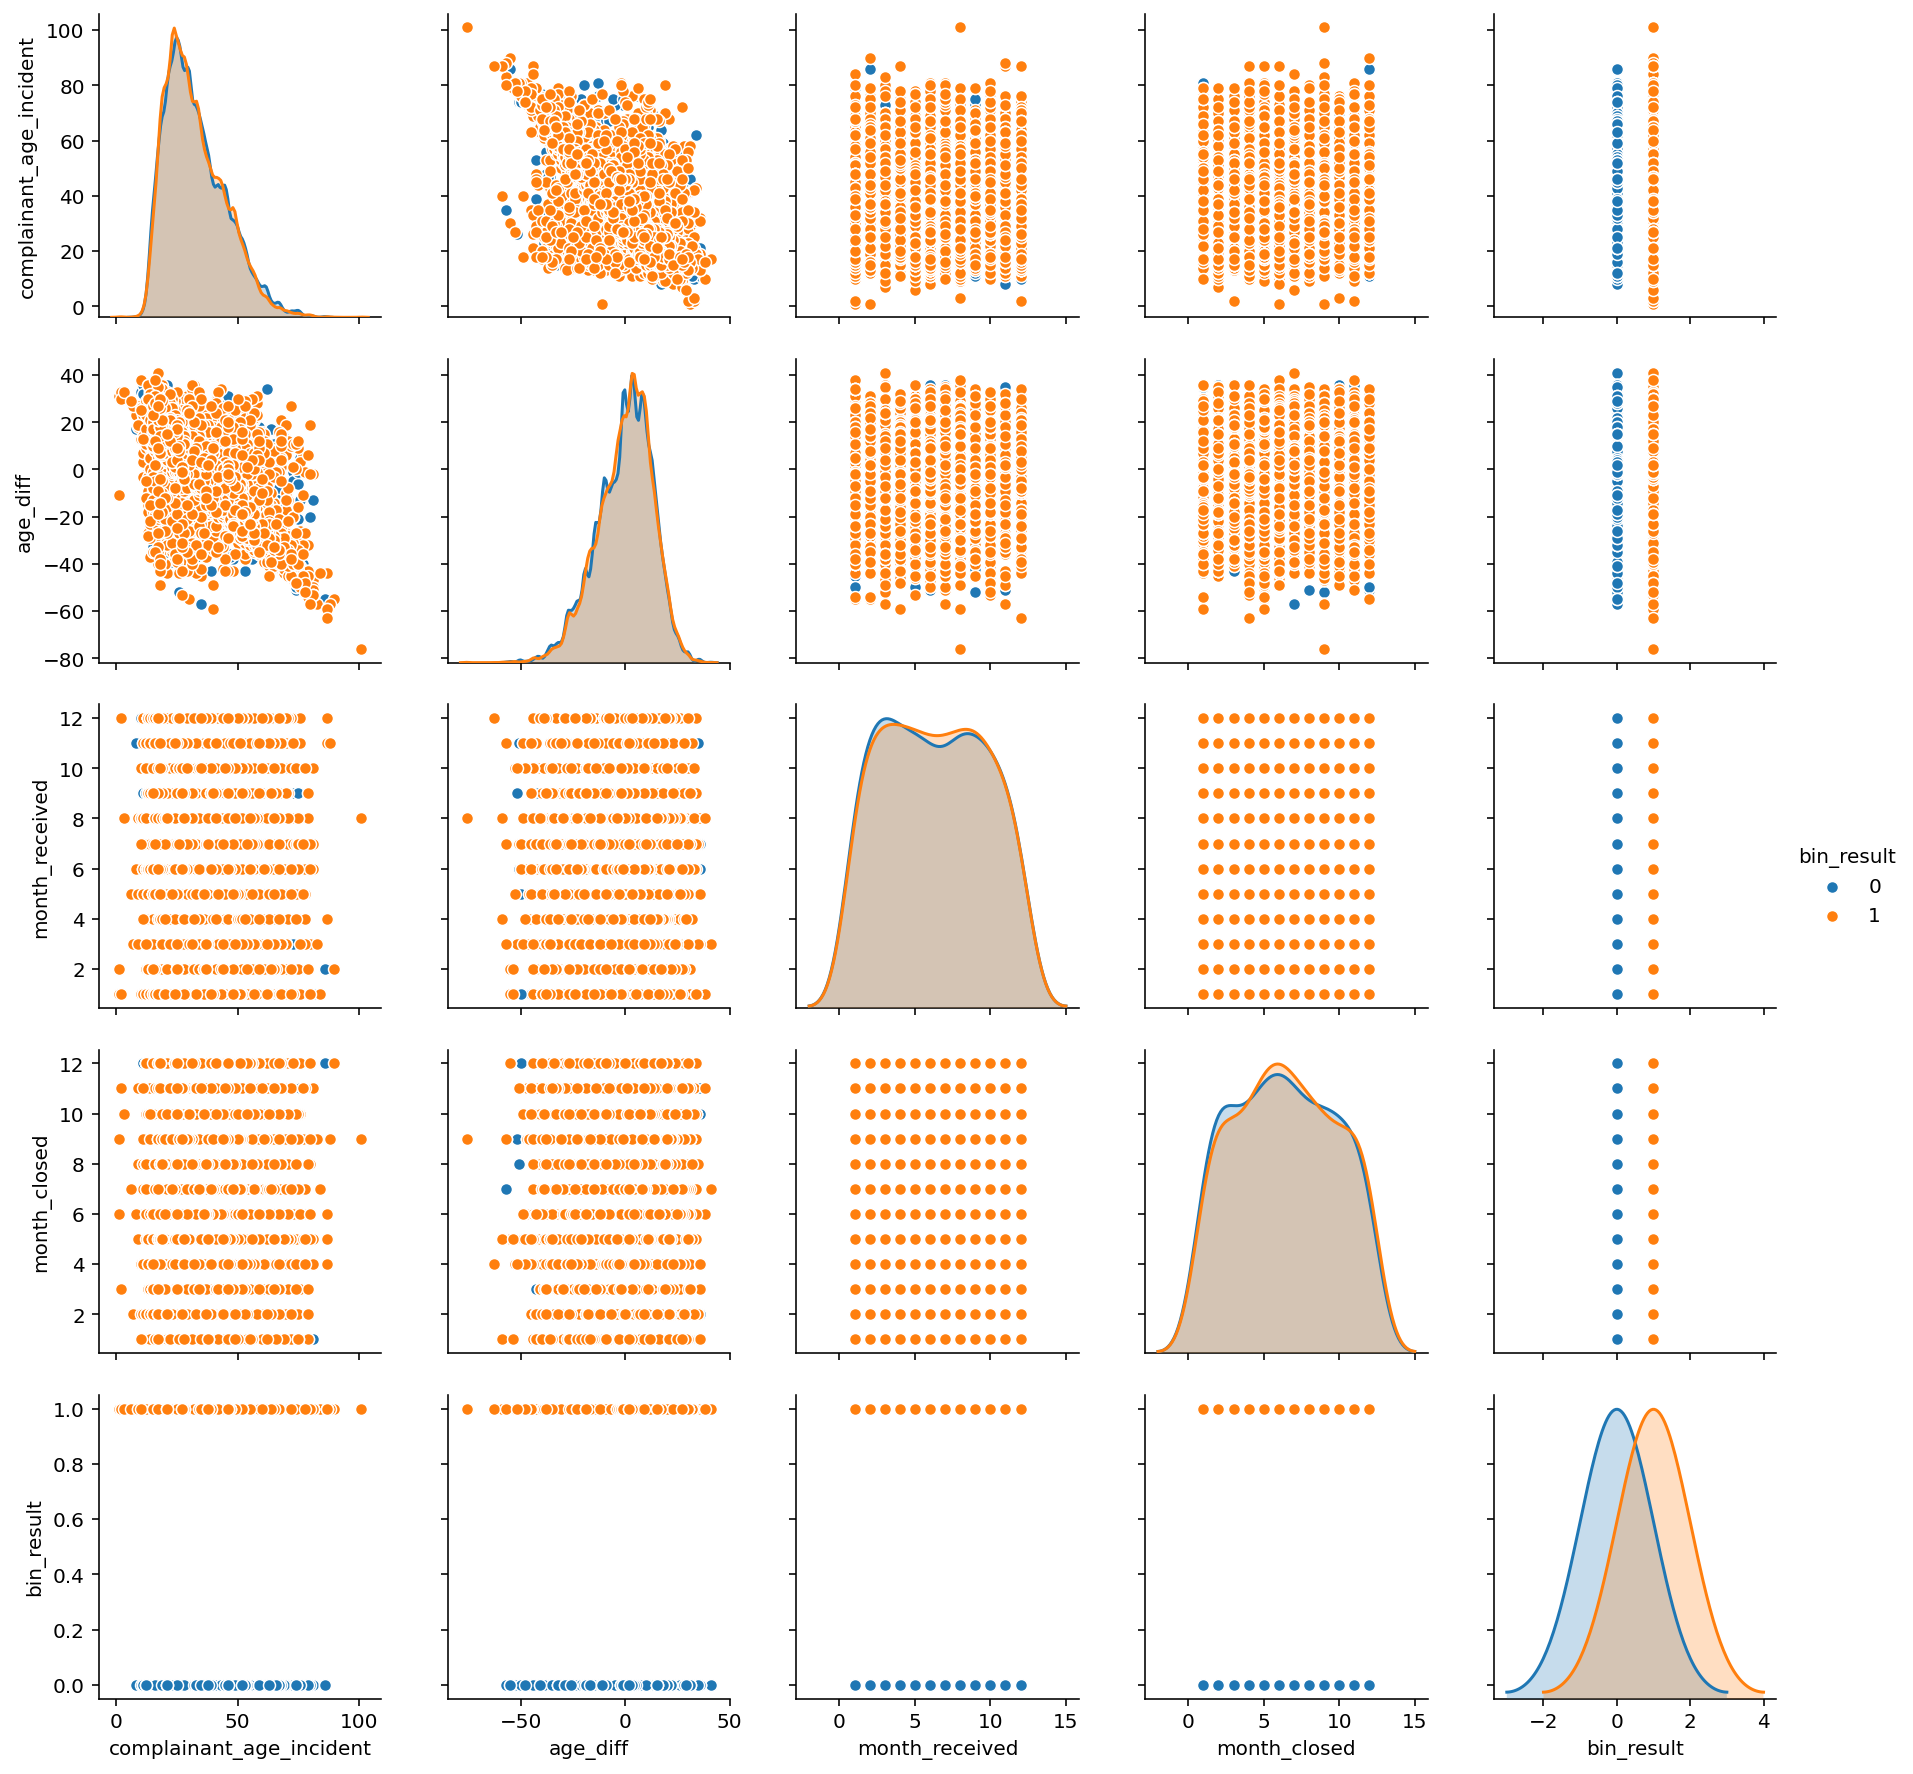

In [231]:
concat_df=pd.concat([temp[['complainant_age_incident', 'age_diff','month_received','month_closed']], allegations.bin_result],axis=1)
concat_df=concat_df.rename(columns={0:"bin_result"})
sns.pairplot(concat_df, hue="bin_result",diag_kws={'bw': 1})
#temp.columns
#concat_df



### Fairness Evaluation

In [ ]:
# TODO
#FP=we classify as substantiated but in reality it isn't
#FN=we classify as non-substantiated but in reality it is substantiated
#True positive: classify as substantiated and in reality it is substantiated
#Precision is utilized in this case, because false positive is more fatal, as we might be underrepresenting disadvantaged complainants, assuming they're actually substantiated while they aren't
#Evaluate based on duration, (0 month - 10 month, 10-max)

#binarize result column to substantiated and non-substantiated (unsubstantiated & exonerated)
allegations["bin_result"]=allegations["result"].apply(binarize_result)
#binarize duration as described above
#allegations["bin_duration"]=allegations["duration"].apply(binarize_duration)
#get precision for original data frame (c0 refers to confusion matrix with duration = [0,10])
#c1 refers to confusion matrix with duration = [10, max]
is_duration0=allegations["bin_duration"]==0
is_duration1=allegations["bin_duration"]==1


#prediction(0,1 after converting substantiated, unsubstantiated, extronerated into binary values)
pred0=convert_col(clf.best_estimator_.predict(allegations.loc[is_duration0].drop(columns=["bin_result","result"])))
pred1=convert_col(clf.best_estimator_.predict(allegations.loc[is_duration1].drop(columns=["bin_result","result"])))
#confusion matrices of first duration group and second duration group
c0=confusion_matrix(allegations["bin_result"].loc[is_duration0],pred0)
c1=confusion_matrix(allegations["bin_result"].loc[is_duration1],pred1)
obs_diff=c0[0,0]/(c0[0,0]+c0[0,1])-c1[0,0]/(c1[0,0]+c1[0,1])
prec_list=[]
for i in range(100):
    #print(allegations.loc["bin_result",0]==None)
    #print(i)
    #allegations["bin_result"]=np.random.shuffle(allegations["bin_result"])
    np.random.shuffle(allegations["bin_result"])
    pred0=convert_col(clf.best_estimator_.predict(allegations.loc[is_duration0].drop(columns=["bin_result","result"])))
    pred1=convert_col(clf.best_estimator_.predict(allegations.loc[is_duration1].drop(columns=["bin_result","result"])))
    c0=confusion_matrix(allegations["bin_result"].loc[is_duration0],pred0)
    c1=confusion_matrix(allegations["bin_result"].loc[is_duration1],pred1)
    diff=c0[0,0]/(c0[0,0]+c0[0,1])-c1[0,0]/(c1[0,0]+c1[0,1])
    prec_list.append(diff)

(prec_list>=obs_diff).mean()



In [8]:
#helper methods
def binarize_result(x):
    if(x=="Substantiated"):
        return 0
    return 1
def binarize_duration(x):
    if(x<=20):
        return 0
    else:
        return 1
def convert_col(x):
    return pd.Series(x).apply(binarize_result)